In [ ]:
using MAT, Statistics, StatsBase, Printf, Plots

N_list = [51, 101, 201, 401, 801, 1601, 3201, 6401]
make_path(N) = "dict/num_points7/blochdict_7mm_$(N)_short.mat"

round2(x) = round(x; digits=6)

function load_dict_and_idx(path::AbstractString)
    mat = matopen(path)
    D   = Array(read(mat, "dict0")) 
    idx = Array{Float64}(read(mat, "idx"))
    close(mat)
    return D, idx
end

function make_idx_map(idx::AbstractMatrix{<:Real})
    m = Dict{Tuple{Float64,Float64},Int}()
    for (i, row) in enumerate(eachrow(idx))
        m[(round2(row[1]), round2(row[2]))] = i
    end
    return m
end

function align_by_idx(Dref::AbstractMatrix, idx_ref::AbstractMatrix,
                      Dmov::AbstractMatrix, idx_mov::AbstractMatrix)
    map_mov = make_idx_map(idx_mov)
    T, K = size(Dref)
    Daligned = similar(Dmov, size(Dref))
    for (j, row) in enumerate(eachrow(idx_ref))
        key = (round2(row[1]), round2(row[2]))
        j2 = get(map_mov, key, 0)
        j2 > 0 || error("Entry $(key) in first file not found in second file.")
        @inbounds Daligned[:, j] = Dmov[:, j2]
    end
    return Daligned
end

"""
Per-column relative L2 error (in %) comparing SA vs SB.
"""
function relative_errors_percent(SA::AbstractMatrix, SB::AbstractMatrix)
    size(SA) == size(SB) || error("Size mismatch: $(size(SA)) vs $(size(SB))")
    diffsq = sum(abs2, SA .- SB; dims=1)
    refsq  = sum(abs2, SB; dims=1)
    err = similar(diffsq, Float64)
    @inbounds for k in eachindex(err)
        r = refsq[k]
        err[k] = r == 0 ? 0.0 : sqrt(diffsq[k]) / sqrt(r) * 100
    end
    return vec(err)
end

summ_stats(x) = (
    median = median(x),
    p95    = quantile(x, 0.95),
    max    = maximum(x),
    rmse   = sqrt(mean(x .^ 2))
)

const T1_RANGES = [
    (100.0,   400.0),
    (400.0,   800.0),
    (800.0,  1500.0),
    (1500.0, 3000.0),
]

const T1_LABELS = ["T₁=100–400 ms", "T₁=400–800 ms", "T₁=800–1500 ms", "T₁=1500–3000 ms"]


t1_mask_band(idx, lo, hi) = (idx[:,1] .>= lo) .& (idx[:,1] .<= hi)

function report_band(name::AbstractString, Dref::AbstractMatrix, Daln::AbstractMatrix,
                     mask::BitVector, N::Int, Nn::Int)
    if !any(mask)
        println("[$name]   (no entries in this band)")
        return (median=NaN, p95=NaN, max=NaN, rmse=NaN)
    end
    D1 = Dref[:, mask] ./ N
    D2 = Daln[:, mask] ./ Nn
    errs = relative_errors_percent(D1, D2)
    st   = summ_stats(errs)
    @printf("[%s]   count=%d   Median=%.3f%%   p95=%.3f%%   Max=%.3f%%   RMSE=%.3f%%\n",
            name, length(errs), st.median, st.p95, st.max, st.rmse)
    return st
end

xvals        = Int[]                          
med_errs     = [Float64[] for _ in 1:4]
rmse_errs    = [Float64[] for _ in 1:4]  
overall_med  = Float64[]
overall_rmse = Float64[]  

for i in 1:length(N_list)-1
    N  = N_list[i]
    Nn = N_list[i+1]

    path_N  = make_path(N)
    path_Nn = make_path(Nn)

    D_N,  idx_N  = load_dict_and_idx(path_N)
    D_Nn, idx_Nn = load_dict_and_idx(path_Nn)

    D_Nn_aligned = align_by_idx(D_N, idx_N, D_Nn, idx_Nn)

    D_N_norm  = D_N ./ N
    D_Nn_norm = D_Nn_aligned ./ Nn
    errs_all  = relative_errors_percent(D_N_norm, D_Nn_norm)
    st_all    = summ_stats(errs_all)

    println("\n$(N) vs $(Nn) spins — overall relative signal error (%):")
    @printf("Median: %.3f%%   p95: %.3f%%   Max: %.3f%%   RMSE: %.3f%%\n",
            st_all.median, st_all.p95, st_all.max, st_all.rmse)

    push!(overall_med,  st_all.median)
    push!(overall_rmse, st_all.rmse)

    println("$(N) vs $(Nn) — relative signal error by T₁ band (%):")
    for (b, (lo, hi)) in enumerate(T1_RANGES)
        mask = t1_mask_band(idx_N, lo, hi)
        st = report_band(T1_LABELS[b], D_N, D_Nn_aligned, mask, N, Nn)
        push!(med_errs[b],  st.median)
        push!(rmse_errs[b], st.rmse)
    end

    push!(xvals, Nn)
end



51 vs 101 spins — overall relative signal error (%):
Median: 5.690%   p95: 15.948%   Max: 33.356%   RMSE: 8.181%
51 vs 101 — relative signal error by T₁ band (%):
[T₁=100–400 ms]   count=950   Median=3.089%   p95=5.635%   Max=7.311%   RMSE=3.386%
[T₁=400–800 ms]   count=1480   Median=4.363%   p95=7.838%   Max=11.672%   RMSE=4.932%
[T₁=800–1500 ms]   count=1736   Median=6.055%   p95=12.741%   Max=19.568%   RMSE=7.266%
[T₁=1500–3000 ms]   count=1840   Median=8.959%   p95=22.629%   Max=33.356%   RMSE=11.833%

101 vs 201 spins — overall relative signal error (%):
Median: 4.530%   p95: 13.308%   Max: 26.094%   RMSE: 6.673%
101 vs 201 — relative signal error by T₁ band (%):
[T₁=100–400 ms]   count=950   Median=2.504%   p95=5.057%   Max=6.214%   RMSE=2.865%
[T₁=400–800 ms]   count=1480   Median=3.620%   p95=6.734%   Max=9.269%   RMSE=4.123%
[T₁=800–1500 ms]   count=1736   Median=4.984%   p95=10.306%   Max=15.042%   RMSE=5.936%
[T₁=1500–3000 ms]   count=1840   Median=7.463%   p95=17.826%   Ma

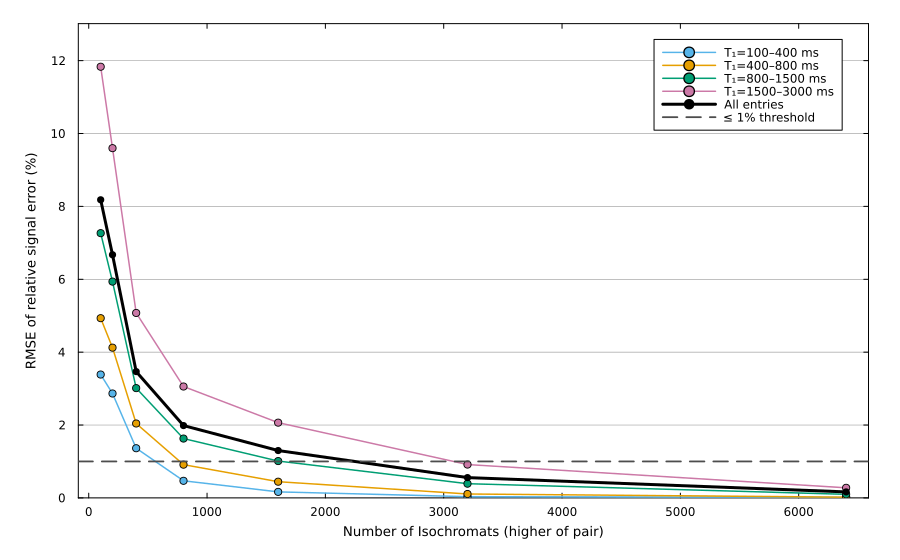

"c:\\Users\\lucya\\MSC_PROJECT\\Dictionary\\convergence_rmse.pdf"

In [59]:
pal = ["#56B4E9", "#E69F00", "#009E73", "#CC79A7", "#000000"]

marker_shape = :circle

default(
    linewidth = 1.5,
    markersize = 4,     # smaller dots
    markerstrokewidth = 0.8,
    gridalpha = 0.25,
)

ymax_rmse = maximum(vcat(overall_rmse, reduce(vcat, rmse_errs))) * 1.1
plt_rmse = plot(
    size       = (900, 560),
    framestyle = :box,
    grid       = :y,
    legend     = :topright,
    xlabel     = "Number of Isochromats (higher of pair)",
    ylabel     = "RMSE of relative signal error (%)",
    ylims      = (0, ymax_rmse),
)

for b in 1:length(T1_LABELS)
    plot!(plt_rmse, xvals, rmse_errs[b];
        label     = T1_LABELS[b],
        color     = pal[b],
        marker    = marker_shape,
        linestyle = :solid,
    )
end

plot!(plt_rmse, xvals, overall_rmse;
    label     = "All entries",
    color     = pal[end],
    marker    = marker_shape,
    linewidth = 3.0,
)

hline!(plt_rmse, [1.0]; color=:gray30, linestyle=:dash, linewidth=1.8, label="≤ 1% threshold")

plot!(plt_rmse;
    guidefont   = font(9),
    tickfont    = font(8),
    legendfont  = font(8),
    left_margin = 8Plots.mm, right_margin = 6Plots.mm,
    top_margin  = 4Plots.mm, bottom_margin = 6Plots.mm,
)

display(plt_rmse)
if save_plot
    savefig(plt_rmse, "convergence_rmse.pdf")
end
